# **Task 1**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil  # For measuring CPU usage
import os
from tensorflow.keras.datasets import cifar10

evaluation_metrics = {
    "pca": {
        "accuracy": None,           # Overall classification accuracy for a single run
        "reconstruction_error": [], # List to store reconstruction errors per hyperparameter setting
        "training_time": None,      # Total time taken for PCA classification
        "cpu_usage_before": None,   # CPU usage before the main task
        "cpu_usage_after": None     # CPU usage after the main task
    },
    "pca_versions": {}  # Will store metrics for each version (e.g., version1, version2, version3)
}



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 419s 2us/step
CIFAR-10 data loaded.
Train images shape (original): (50000, 32, 32, 3)
Test images shape (original): (10000, 32, 32, 3)


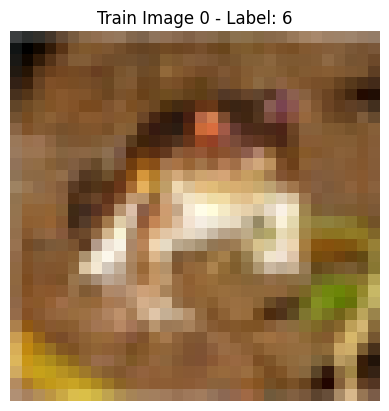

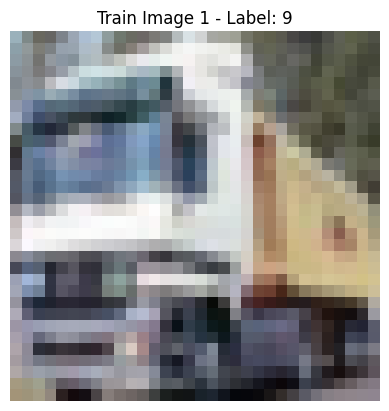

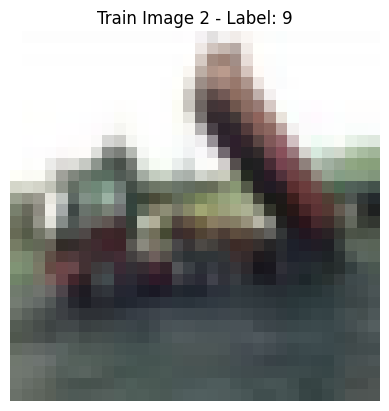

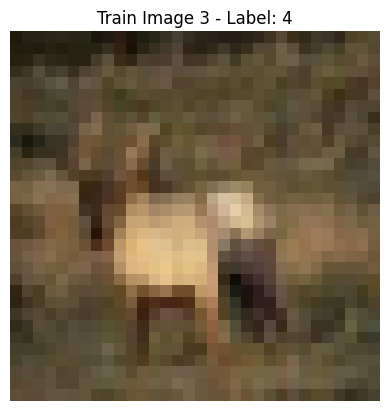

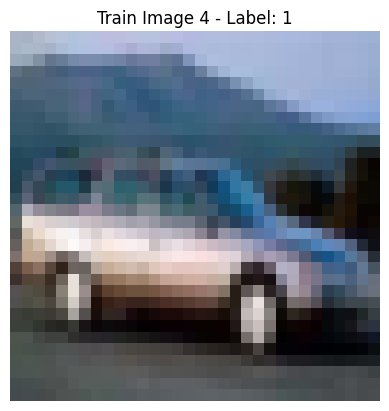

In [7]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("CIFAR-10 data loaded.")
print("Train images shape (original):", train_images.shape)
print("Test images shape (original):", test_images.shape)

number_of_images_to_display = 5
for index in range(number_of_images_to_display):
    plt.figure()
    plt.imshow(train_images[index])
    plt.title("Train Image " + str(index) + " - Label: " + str(train_labels[index][0]))
    plt.axis("off")
    plt.show()

Normalize pixel values

In [9]:
train_images_normalized = train_images.astype(np.float32) / 255.0
test_images_normalized = test_images.astype(np.float32) / 255.0

Reshape images

In [10]:
num_train_samples = train_images_normalized.shape[0]
num_test_samples = test_images_normalized.shape[0]


train_images_flat = train_images_normalized.reshape(num_train_samples, 32 * 32 * 3)
test_images_flat = test_images_normalized.reshape(num_test_samples, 32 * 32 * 3)

print("Train images shape (flattened):", train_images_flat.shape)
print("Test images shape (flattened):", test_images_flat.shape)

Train images shape (flattened): (50000, 3072)
Test images shape (flattened): (10000, 3072)


 Group Training Samples by Class

In [11]:
unique_classes = np.unique(train_labels)
print("Unique classes found:", unique_classes)

train_images_by_class = {}
for current_label in unique_classes:
    indices = np.where(train_labels.flatten() == current_label)[0]
    train_images_by_class[current_label] = train_images_flat[indices]
    print("Class", current_label, "has", train_images_by_class[current_label].shape[0], "samples.")

print("Training data grouped by class.")


Unique classes found: [0 1 2 3 4 5 6 7 8 9]
Class 0 has 5000 samples.
Class 1 has 5000 samples.
Class 2 has 5000 samples.
Class 3 has 5000 samples.
Class 4 has 5000 samples.
Class 5 has 5000 samples.
Class 6 has 5000 samples.
Class 7 has 5000 samples.
Class 8 has 5000 samples.
Class 9 has 5000 samples.
Training data grouped by class.


imp func for PCA as It will be a mess If I copy paste for each version 
<br>
all detials are in steps in the report

In [12]:

def compute_mean(data_array):
    mean_vector = np.mean(data_array, axis=0)
    return mean_vector

# mean - data_i so thta all dats is on the origin and values are simplified for calculations
def center_data(data_array, mean_vector):

    centered_data = data_array - mean_vector
    return centered_data



def compute_covariance_matrix(centered_data):

    covariance_matrix = np.cov(centered_data, rowvar=False)
    return covariance_matrix



def perform_eigen_decomposition(covariance_matrix):
    
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors



def reconstruct_sample(sample, mean_vector, principal_components):
    
    centered_sample = sample - mean_vector
    projection_coefficients = np.dot(centered_sample, principal_components)
    
    reconstructed_sample = mean_vector + np.dot(projection_coefficients, principal_components.T)
    return reconstructed_sample



def classify_sample_using_pca(test_sample, pca_model_dictionary):
    error_list = []
    
    for current_label in sorted(pca_model_dictionary.keys()):
        class_mean, principal_components = pca_model_dictionary[current_label]
        reconstructed_sample = reconstruct_sample(test_sample, class_mean, principal_components)
        mse_error = np.mean((test_sample - reconstructed_sample) ** 2)
        error_list.append(mse_error)
    
    
    predicted_class = np.argmin(np.array(error_list))
    return predicted_class, error_list



Train an evaluate pca for different versions
<br>
See the first line of the report for more details of the version that I have chose


In [13]:
versions = {
    "version1": 15,  # Low
    "version2": 30,  # Normal 
    "version3": 40   # Theoretical optimum, hi has not been chosen as my laptop cannot support it
}

evaluation_metrics["pca_versions"] = {}

# i am not writing details about each step as I have already written them in the report
for version_label, k_value in versions.items():
    print("\nProcessing", version_label, "with k =", k_value)
    
    pca_models_current = {}
    
    for current_label in unique_classes:
        class_data = train_images_by_class[current_label]

        # Step 1
        class_mean = compute_mean(class_data)
        print("Class", current_label, "-", version_label, ": Mean vector computed.")
        
        # Step 2
        centered_data = center_data(class_data, class_mean)
        print("Class", current_label, "-", version_label, ": Data centered.")
        
        # Step 3
        covariance_matrix = compute_covariance_matrix(centered_data)
        print("Class", current_label, "-", version_label, ": Covariance matrix computed.")
        
        # Step 4
        eigenvalues, eigenvectors = perform_eigen_decomposition(covariance_matrix)
        print("Class", current_label, "-", version_label, ": Eigen-decomposition performed.")
        
        # Step 5
        principal_components = eigenvectors[:, :k_value]
        print("Class", current_label, "-", version_label, ": Selected top", k_value, "principal components.")
        
        # Save the PCA model 
        pca_models_current[current_label] = (class_mean, principal_components)
    
    # Save the current version
    output_directory = os.path.join("task1_output", "versions", version_label + "_model")
    os.makedirs(output_directory, exist_ok=True)
    for current_label in unique_classes:
        mean_vector, principal_components = pca_models_current[current_label]
        np.save(os.path.join(output_directory, "class_" + str(current_label) + "_mean.npy"), mean_vector)
        np.save(os.path.join(output_directory, "class_" + str(current_label) + "_pcs.npy"), principal_components)
    print("Models for", version_label, "saved to directory:", output_directory)
    
    # Classify test images using the current version's PCA models
    predicted_labels_current = []
    min_error_list = []  # To collect the minimum error for each test sample
    cpu_usage_before_version = psutil.cpu_percent(interval=1)
    start_time_version = time.time()
    for i in range(test_images_flat.shape[0]):
        test_sample = test_images_flat[i]
        predicted_class, error_values = classify_sample_using_pca(test_sample, pca_models_current)
        predicted_labels_current.append(predicted_class)
        min_error = min(error_values)
        min_error_list.append(min_error)
        if i < 5:
            print("Test sample", i, "errors:", error_values, "-> Predicted class:", predicted_class)
    end_time_version = time.time()
    cpu_usage_after_version = psutil.cpu_percent(interval=1)
    
    classification_time = end_time_version - start_time_version
    predicted_labels_current_array = np.array(predicted_labels_current)
    num_correct = np.sum(predicted_labels_current_array == test_labels.flatten())
    accuracy = (num_correct / test_labels.shape[0]) * 100
    average_error = np.mean(min_error_list)
    
    # Store evaluation metrics for the current version
    evaluation_metrics["pca_versions"][version_label] = {
        "accuracy": accuracy,
        "classification_time": classification_time,
        "cpu_usage_before": cpu_usage_before_version,
        "cpu_usage_after": cpu_usage_after_version,
        "average_reconstruction_error": average_error,
        "k_value": k_value
    }
    
    print("\nResults for", version_label, ":")
    print("Accuracy: {:.2f}%".format(accuracy))
    print("Classification time (seconds):", classification_time)
    print("CPU usage before: {}%, after: {}%".format(cpu_usage_before_version, cpu_usage_after_version))
    print("Average reconstruction error (MSE):", average_error)

print("\nAll versions processed. Evaluation metrics for PCA versions:")
print(evaluation_metrics["pca_versions"])



Processing version1 with k = 15
Class 0 - version1 : Mean vector computed.
Class 0 - version1 : Data centered.
Class 0 - version1 : Covariance matrix computed.
Class 0 - version1 : Eigen-decomposition performed.
Class 0 - version1 : Selected top 15 principal components.
Class 1 - version1 : Mean vector computed.
Class 1 - version1 : Data centered.
Class 1 - version1 : Covariance matrix computed.
Class 1 - version1 : Eigen-decomposition performed.
Class 1 - version1 : Selected top 15 principal components.
Class 2 - version1 : Mean vector computed.
Class 2 - version1 : Data centered.
Class 2 - version1 : Covariance matrix computed.
Class 2 - version1 : Eigen-decomposition performed.
Class 2 - version1 : Selected top 15 principal components.
Class 3 - version1 : Mean vector computed.
Class 3 - version1 : Data centered.
Class 3 - version1 : Covariance matrix computed.
Class 3 - version1 : Eigen-decomposition performed.
Class 3 - version1 : Selected top 15 principal components.
Class 4 - v

### Visualizations in the mattress comparisons

Print Evaluation Metrics for All Versions

In [ ]:
print("PCA Version Evaluation:")
for version_label, metrics in evaluation_metrics["pca_versions"].items():
    print("Version:", version_label)
    print(" k value:", metrics["k_value"])
    print(" Accuracy:", metrics["accuracy"])
    print(" Avg Reconstruction Error:", metrics["average_reconstruction_error"])
    print(" Classification Time:", metrics["classification_time"])
    print(" CPU usage before:", metrics["cpu_usage_before"])
    print(" CPU usage after:", metrics["cpu_usage_after"])
    print("")
    
best_version = max(evaluation_metrics["pca_versions"].keys(), key=lambda v: evaluation_metrics["pca_versions"][v]["accuracy"])
print("The best version is", best_version)


PCA Version Evaluation:
Version: version1
 k value: 15
 Accuracy: 35.31
 Avg Reconstruction Error: 0.016336881194533793
 Classification Time: 4.6901609897613525
 CPU usage before: 8.5
 CPU usage after: 3.2

Version: version2
 k value: 30
 Accuracy: 38.46
 Avg Reconstruction Error: 0.011887542678629537
 Classification Time: 7.714103698730469
 CPU usage before: 3.1
 CPU usage after: 4.0

Version: version3
 k value: 40
 Accuracy: 38.73
 Avg Reconstruction Error: 0.010225378052785356
 Classification Time: 9.2605619430542
 CPU usage before: 5.8
 CPU usage after: 4.5

The best version is version3


Visualize Original and Reconstructed Images for All Versions

Visualizing images for version1


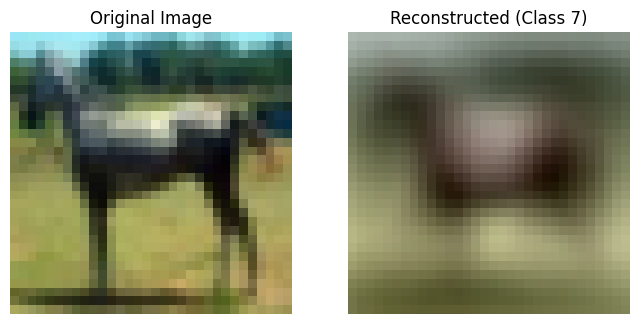

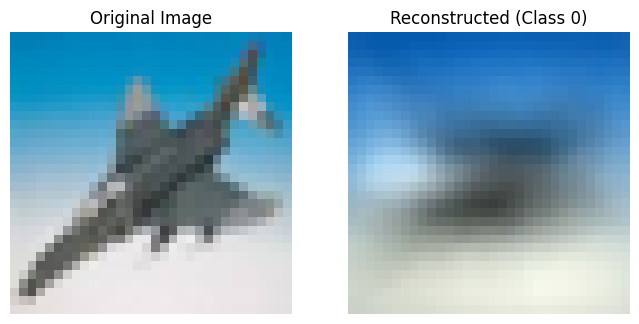

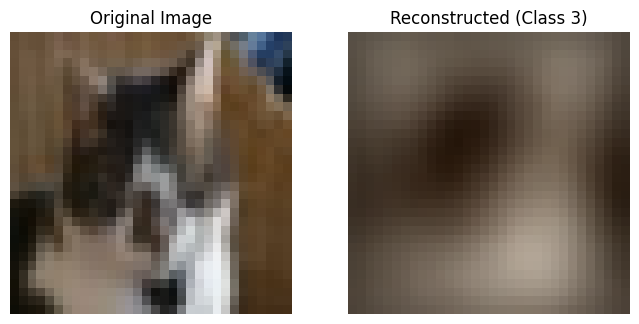

Visualizing images for version2


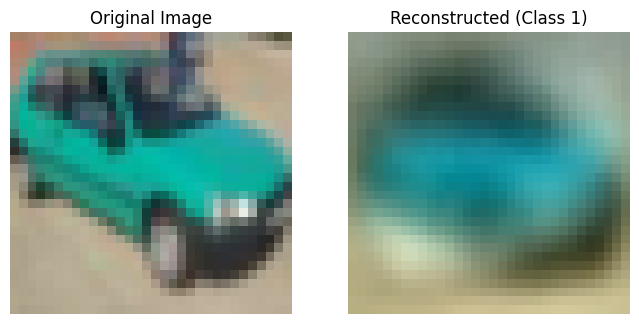

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0035302095789438437..0.943173348428037].


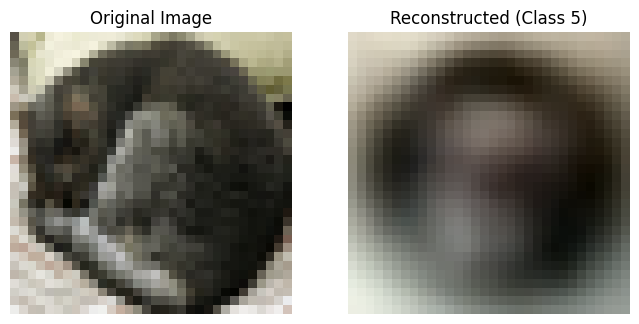

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07982225040132862..1.026681847900511].


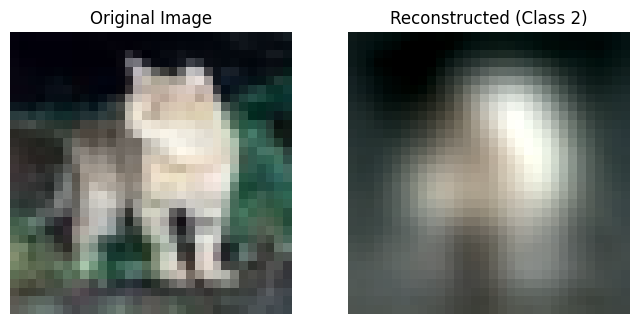

Visualizing images for version3


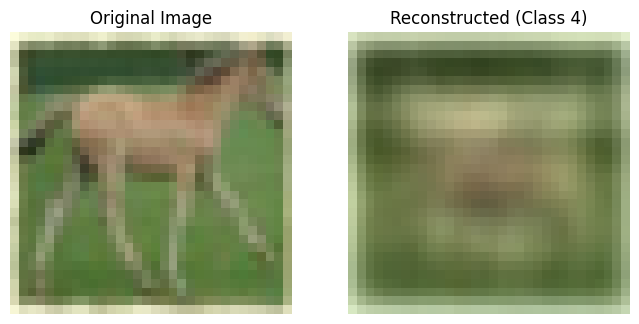

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.126403107497092..1.015884658565433].


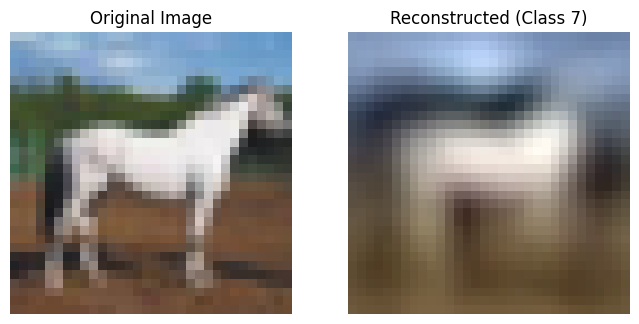

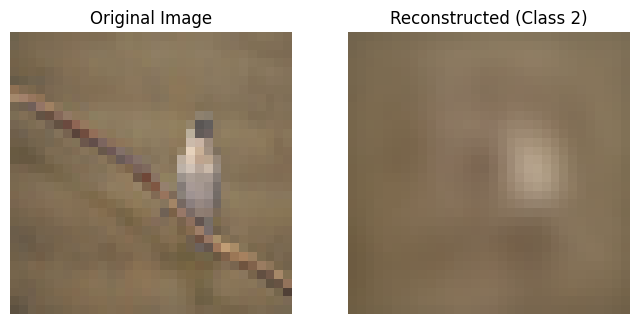

In [ ]:
import os

for version_label in versions.keys():
    print("Visualizing images for", version_label)
    
    # Load the PCA models 
    pca_models_version = {}
    output_directory = os.path.join("task1_output", "versions", version_label + "_model")
    for current_label in unique_classes:
        mean_file = os.path.join(output_directory, "class_" + str(current_label) + "_mean.npy")
        pcs_file = os.path.join(output_directory, "class_" + str(current_label) + "_pcs.npy")
        class_mean = np.load(mean_file)
        principal_components = np.load(pcs_file)
        pca_models_version[current_label] = (class_mean, principal_components)
    
    random_indices = np.random.choice(test_images_flat.shape[0], 3, replace=False)
    for index in random_indices:
        original_sample = test_images_flat[index]
        predicted_class, errors = classify_sample_using_pca(original_sample, pca_models_version)
        class_mean, principal_components = pca_models_version[predicted_class]
        reconstructed_sample = reconstruct_sample(original_sample, class_mean, principal_components)
        
        original_image = original_sample.reshape(32, 32, 3)
        reconstructed_image = reconstructed_sample.reshape(32, 32, 3)
        
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_image)
        plt.title("Reconstructed (Class " + str(predicted_class) + ")")
        plt.axis("off")
        plt.show()


Draw Comparison Graph for All Versions

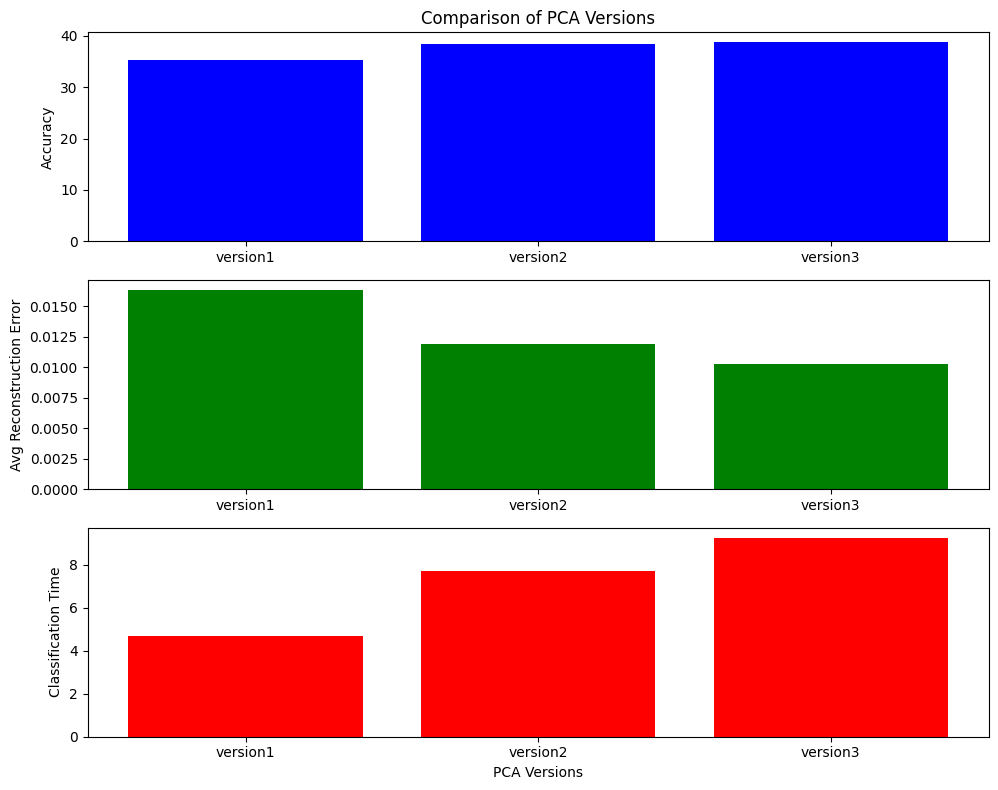

Graph comparison complete. The best version is version3


In [18]:
version_names = []
accuracy_list = []
error_list = []
time_list = []

for version_label, metrics in evaluation_metrics["pca_versions"].items():
    version_names.append(version_label)
    accuracy_list.append(metrics["accuracy"])
    error_list.append(metrics["average_reconstruction_error"])
    time_list.append(metrics["classification_time"])

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.bar(version_names, accuracy_list, color="blue")
plt.ylabel("Accuracy")
plt.title("Comparison of PCA Versions")

plt.subplot(3, 1, 2)
plt.bar(version_names, error_list, color="green")
plt.ylabel("Avg Reconstruction Error")

plt.subplot(3, 1, 3)
plt.bar(version_names, time_list, color="red")
plt.ylabel("Classification Time")
plt.xlabel("PCA Versions")

plt.tight_layout()
plt.show()

print("Graph comparison complete. The best version is", best_version)


these things are only for Things ask about task number one in the Documentation

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train_raw = train_images_flat 
y_train = train_labels.flatten()
X_test_raw = test_images_flat
y_test = test_labels.flatten()

clf_raw = LogisticRegression(max_iter=1000)
clf_raw.fit(X_train_raw, y_train)
y_pred_raw = clf_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test, y_pred_raw)
print("Accuracy on raw data:", accuracy_raw)


c:\Users\afsah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on raw data: 0.3866


In [20]:
def apply_pca_global(X, k):
    mean_vector = np.mean(X, axis=0)
    X_centered = X - mean_vector
    covariance_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_indices][:, :k]
    X_projected = np.dot(X_centered, top_eigenvectors)
    return X_projected, mean_vector, top_eigenvectors

# Apply PCA with k = 50
k_value = 50
X_train_pca, mean_vector, top_eigenvectors = apply_pca_global(X_train_raw, k_value)
X_test_pca = np.dot(X_test_raw - mean_vector, top_eigenvectors)

clf_pca = LogisticRegression(max_iter=1000)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy with PCA (k=50):", accuracy_pca)


Accuracy with PCA (k=50): 0.3776


k = 10 Accuracy = 0.3199
k = 50 Accuracy = 0.3776
k = 150 Accuracy = 0.4035


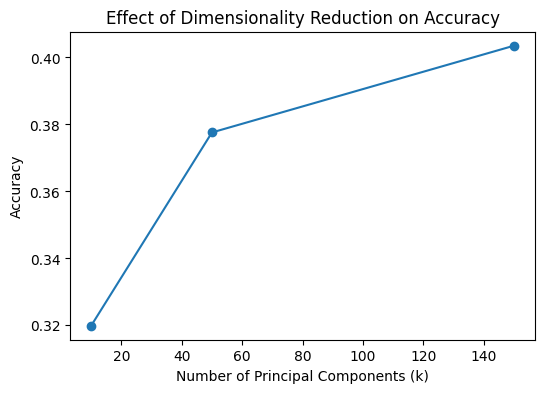

In [ ]:
k_values = [10, 50, 150]
accuracies = []

for k in k_values:
    X_train_pca, mean_vector, top_eigenvectors = apply_pca_global(X_train_raw, k)
    X_test_pca = np.dot(X_test_raw - mean_vector, top_eigenvectors)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print("k =", k, "Accuracy =", acc)

plt.figure(figsize=(6, 4))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Accuracy")
plt.title("Effect of Dimensionality Reduction on Accuracy")
plt.show()


# TASK 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as transforms
import time
import os
import psutil
import matplotlib.pyplot as plt
device = torch.device("cpu")

evaluation_metrics_task2 = {
    "version1": {},
    "version2": {},
    "version3": {}
}


Load and Preprocess CIFAR-10 Data
<br>
convert images to tensors and normalize them

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))


Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 datasets loaded.
Number of training samples: 50000
Number of test samples: 10000


NN Architecture

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_conv_layers=2, num_filters=32, num_fc_units=128):
        super(SimpleCNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_filters, kernel_size=3, padding=1)
        
        self.additional_convs = nn.ModuleList()

        for i in range(num_conv_layers - 1):
            conv_layer = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding=1)
            self.additional_convs.append(conv_layer)
        
        dummy_input = torch.zeros(1, 3, 32, 32)

        x = self.pool(F.relu(self.conv1(dummy_input)))


        for conv in self.additional_convs:
            x = self.pool(F.relu(conv(x)))


        conv_output_size = x.numel()  
        
        self.fc1 = nn.Linear(conv_output_size, num_fc_units)
        self.fc2 = nn.Linear(num_fc_units, 10) # as we have 10 classes 
        


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        for conv in self.additional_convs:
            x = self.pool(F.relu(conv(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



def create_model(version_parameters):
    model = SimpleCNN(num_conv_layers=version_parameters['num_conv_layers'], num_filters=version_parameters['num_filters'], num_fc_units=version_parameters['num_fc_units'])
    return model.to(device)


Define Training and Evaluation Functions

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    
    model.train()
    training_losses = []
   
   
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_index, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass 
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
       
       
        epoch_loss = running_loss / len(train_loader)
        training_losses.append(epoch_loss)
        print("Epoch", epoch + 1, "loss:", epoch_loss)
    return training_losses




def evaluate_model(model, test_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    
    
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy


Train and Evaluate Three Different Versions

In [ ]:
versions_parameters = {
    "version1": {
        "num_conv_layers": 2,  
        "num_filters": 32,
        "num_fc_units": 128,
        "learning_rate": 0.001,
        "batch_size": 64,
        "num_epochs": 5
    },
    "version2": {
        "num_conv_layers": 3, 
        "num_filters": 32,
        "num_fc_units": 128,
        "learning_rate": 0.005,
        "batch_size": 32,
        "num_epochs": 5
    },
    "version3": {
        "num_conv_layers": 2, 
        "num_filters": 64,    
        "num_fc_units": 256,
        "learning_rate": 0.0005,
        "batch_size": 128,
        "num_epochs": 5
    }
}

version_loss_curves = {}

for version_name, params in versions_parameters.items():
    print("\nTraining", version_name)
    
    model = create_model(params)
    print("Model created for", version_name)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    
    cpu_before = psutil.cpu_percent(interval=1)
    print("CPU usage before training:", cpu_before)
    
    start_time = time.time()
    training_loss_curve = train_model(model, train_loader, loss_function, optimizer, params["num_epochs"])
    end_time = time.time()
    training_time = end_time - start_time
    print("Training completed in", training_time, "seconds")
    
    cpu_after = psutil.cpu_percent(interval=1)
    print("CPU usage after training:", cpu_after)
    
    test_accuracy = evaluate_model(model, test_loader)
    print("Test Accuracy for", version_name, ":", test_accuracy)
    
    version_output_dir = os.path.join("task2_output", version_name + "_model")
    if not os.path.exists(version_output_dir):
        os.makedirs(version_output_dir)
    model_file_path = os.path.join(version_output_dir, "model_state_dict.pth")
    torch.save(model.state_dict(), model_file_path)
    print("Model saved to", model_file_path)
    
    evaluation_metrics_task2[version_name] = {
        "accuracy": test_accuracy,
        "training_time": training_time,
        "cpu_usage_before": cpu_before,
        "cpu_usage_after": cpu_after,
        "loss_curve": training_loss_curve,
        "batch_size": params["batch_size"],
        "learning_rate": params["learning_rate"],
        "num_conv_layers": params["num_conv_layers"]
    }
    
    version_loss_curves[version_name] = training_loss_curve

print("\nAll versions trained and evaluated.")
print("Evaluation metrics:")
print(evaluation_metrics_task2)



Training version1
Model created for version1
CPU usage before training: 31.3
Epoch 1 loss: 1.415604571476007
Epoch 2 loss: 1.0571707080849602
Epoch 3 loss: 0.917950361890866
Epoch 4 loss: 0.8174506462443515
Epoch 5 loss: 0.7393214683551008
Training completed in 158.46793127059937 seconds
CPU usage after training: 12.4
Test Accuracy for version1 : 69.83
Model saved to task2_output\version1_model\model_state_dict.pth

Training version2
Model created for version2
CPU usage before training: 16.2
Epoch 1 loss: 1.4862596139416662
Epoch 2 loss: 1.2442053736057026
Epoch 3 loss: 1.140337975911429
Epoch 4 loss: 1.0860100613903405
Epoch 5 loss: 1.0445084503577142
Training completed in 168.73739361763 seconds
CPU usage after training: 11.9
Test Accuracy for version2 : 61.19
Model saved to task2_output\version2_model\model_state_dict.pth

Training version3
Model created for version3
CPU usage before training: 11.6
Epoch 1 loss: 1.4411029384264251
Epoch 2 loss: 1.0897801599234267
Epoch 3 loss: 0.93

Visualize Loss Curves and Comparison Graphs for All Versions

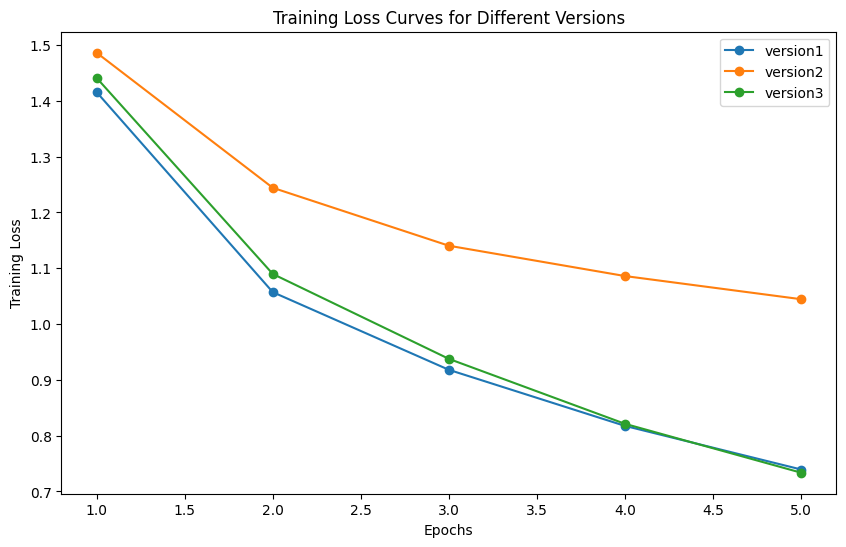

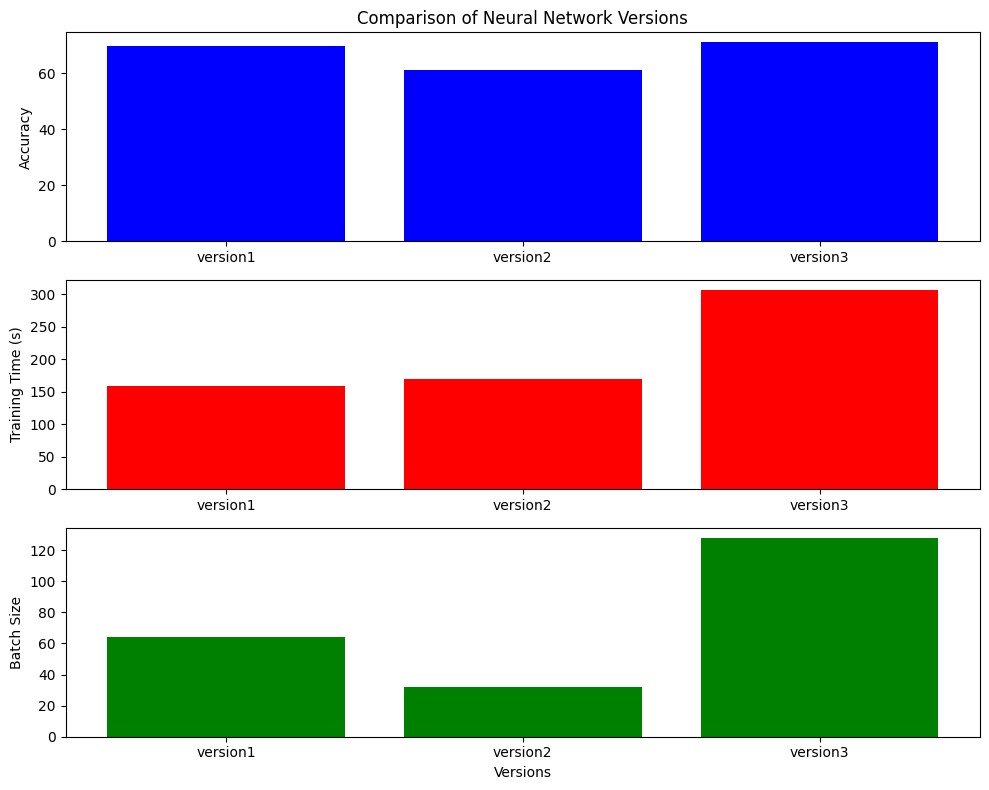

The best neural network version is version3 with accuracy 70.98


In [ ]:
plt.figure(figsize=(10, 6))
for version_name, loss_curve in version_loss_curves.items():
    epochs = list(range(1, len(loss_curve) + 1))
    plt.plot(epochs, loss_curve, marker='o', label=version_name)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Versions")
plt.legend()
plt.show()

version_names = []
accuracy_list = []
time_list = []
batch_sizes = []

for version_name, metrics in evaluation_metrics_task2.items():
    version_names.append(version_name)
    accuracy_list.append(metrics["accuracy"])
    time_list.append(metrics["training_time"])
    batch_sizes.append(metrics["batch_size"])

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.bar(version_names, accuracy_list, color="blue")
plt.ylabel("Accuracy")
plt.title("Comparison of Neural Network Versions")

plt.subplot(3, 1, 2)
plt.bar(version_names, time_list, color="red")
plt.ylabel("Training Time (s)")

plt.subplot(3, 1, 3)
plt.bar(version_names, batch_sizes, color="green")
plt.ylabel("Batch Size")
plt.xlabel("Versions")

plt.tight_layout()
plt.show()

best_version_task2 = max(evaluation_metrics_task2.keys(), key=lambda v: evaluation_metrics_task2[v]["accuracy"])
print("The best neural network version is", best_version_task2, "with accuracy", evaluation_metrics_task2[best_version_task2]["accuracy"])


# TASK 3

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import time
import psutil
import matplotlib.pyplot as plt

device = torch.device("cpu")

evaluation_metrics_task3 = {} 

Loading <br> 
convert images to tensors and normalize them Here we use normalization to range [-1, 1].

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))


Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of test samples: 10000


Group Training Samples by Class

In [40]:
# Group training samples by class (10 classes: 0-9)
train_data_by_class = {}

for label in range(10):
    
    indices = [i for i, (_, lbl) in enumerate(train_dataset) if lbl == label]
    samples = [train_dataset[i][0] for i in indices]
    train_data_by_class[label] = torch.stack(samples)
   
    print("Class", label, "has", train_data_by_class[label].shape[0], "samples")

print("Training data grouped by class.")


Class 0 has 5000 samples
Class 1 has 5000 samples
Class 2 has 5000 samples
Class 3 has 5000 samples
Class 4 has 5000 samples
Class 5 has 5000 samples
Class 6 has 5000 samples
Class 7 has 5000 samples
Class 8 has 5000 samples
Class 9 has 5000 samples
Training data grouped by class.


 Autoencoder Network

In [41]:
# autoencoder that works on flattened images
class Autoencoder(nn.Module):
    def __init__(self, input_size=3072, encoding_dim=256):
        
        super(Autoencoder, self).__init__()
        
        
        # Encoder: reduce dimension
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, encoding_dim),
            nn.ReLU()
        )
        
        
        # Decoder: reconstruct image from encoded representation
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_size),
            nn.Tanh()  # normalized to [-1, 1] bby tanh
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def create_autoencoder(encoding_dim):
    model = Autoencoder(encoding_dim=encoding_dim)
    return model.to(device)


Training Function 

In [42]:
def train_autoencoder(model, data_tensor, num_epochs, batch_size, learning_rate):
    
    model.train()
    num_samples = data_tensor.shape[0]
    
    # Flatten images: from (N, 3, 32, 32) to (N, 3072)
    data_tensor_flat = data_tensor.view(num_samples, -1)
    
    #  DataLoader 
    dataset = torch.utils.data.TensorDataset(data_tensor_flat)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # loss function and optimizer (Mean Squared Error and Adam)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    

    
    training_losses = []
    
    
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        
        for batch in data_loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(data_loader)
        training_losses.append(epoch_loss)
        
        print("Epoch", epoch + 1, "loss:", epoch_loss)
    
    
    return training_losses


Train Autoencoders for Three Versions

In [ ]:
output_dir_task3 = "task3_output"

versions_parameters = {
    "version1": {
        "encoding_dim": 128,  # Lower capacity encoding
        "num_epochs": 5,
        "batch_size": 64,
        "learning_rate": 0.001
    },
    "version2": {
        "encoding_dim": 256,  # Moderate encoding capacity
        "num_epochs": 5,
        "batch_size": 32,
        "learning_rate": 0.0005
    },
    "version3": {
        "encoding_dim": 64,   
        "num_epochs": 5,
        "batch_size": 128,
        "learning_rate": 0.001
    }
}

# Dic to store trained autoencoder models for each version
autoencoder_models_versions = {}  # keys: version names, value: dict mapping class label -> model
autoencoder_loss_curves_versions = {}  # to store loss curves for each version




# for each version 
for version_name, params in versions_parameters.items():
    print("\nTraining Autoencoders for", version_name)
    models_for_version = {}
    loss_curves_for_version = {}

    # for each class     
    for class_label in range(10):
       
       
        print(" Training autoencoder for class", class_label)
        model = create_autoencoder(params["encoding_dim"])
        class_data = train_data_by_class[class_label]
        

        cpu_before = psutil.cpu_percent(interval=1)
        print("  CPU usage before training:", cpu_before)
        

        start_time = time.time()
        loss_curve = train_autoencoder(model, class_data, params["num_epochs"], params["batch_size"], params["learning_rate"])
        end_time = time.time()
        training_time = end_time - start_time
        print("  Training completed in", training_time, "seconds")

        
        cpu_after = psutil.cpu_percent(interval=1)
        print("  CPU usage after training:", cpu_after)
        
        # Save the model 
        version_output_dir = os.path.join(output_dir_task3, version_name, "class_" + str(class_label) + "_model")
        os.makedirs(version_output_dir, exist_ok=True)
        model_file = os.path.join(version_output_dir, "autoencoder_state_dict.pth")
        torch.save(model.state_dict(), model_file)
        print("  Model saved to", model_file)
        


        models_for_version[class_label] = model
        loss_curves_for_version[class_label] = loss_curve
    
    
    
    autoencoder_models_versions[version_name] = models_for_version
    autoencoder_loss_curves_versions[version_name] = loss_curves_for_version

print("")
print("")
print("Doneeee!")



Training Autoencoders for version1
 Training autoencoder for class 0
  CPU usage before training: 9.4
Epoch 1 loss: 0.10778243405909478
Epoch 2 loss: 0.0651915827412394
Epoch 3 loss: 0.052389078926813756
Epoch 4 loss: 0.04573844585426246
Epoch 5 loss: 0.04186335894503171
  Training completed in 30.627506017684937 seconds
  CPU usage after training: 49.7
  Model saved to task3_output\version1\class_0_model\autoencoder_state_dict.pth
 Training autoencoder for class 1
  CPU usage before training: 21.4
Epoch 1 loss: 0.13398436419194257
Epoch 2 loss: 0.08344049949811984
Epoch 3 loss: 0.06873178005784372
Epoch 4 loss: 0.06199026371859297
Epoch 5 loss: 0.057590942405447175
  Training completed in 32.79158878326416 seconds
  CPU usage after training: 18.4
  Model saved to task3_output\version1\class_1_model\autoencoder_state_dict.pth
 Training autoencoder for class 2
  CPU usage before training: 17.5
Epoch 1 loss: 0.0917807337886925
Epoch 2 loss: 0.056589655908225456
Epoch 3 loss: 0.046686084

Classify Test Images 

In [47]:
def classify_sample_autoencoder(test_sample, autoencoder_dict):

    # Flatten test sample: from (3, 32, 32) to (1, 3072)
    test_sample_flat = test_sample.view(1, -1).to(device)
    errors = []

    for class_label, model in autoencoder_dict.items():

        model.eval()

        with torch.no_grad():
            reconstructed = model(test_sample_flat)
            mse_error = torch.mean((test_sample_flat - reconstructed) ** 2).item()
            errors.append(mse_error)

    
    predicted_class = np.argmin(np.array(errors))
    
    return predicted_class, errors




#for each version
for version_name, models_dict in autoencoder_models_versions.items():
    
    print("\nEvaluating classification for", version_name)
    
    correct = 0
    total = 0
    errors_all = []
    
    for i in range(len(test_dataset)):
        test_image, true_label = test_dataset[i]
        predicted_class, error_values = classify_sample_autoencoder(test_image, models_dict)
        total += 1
    
        if predicted_class == true_label:
            correct += 1
    
        errors_all.append(min(error_values))
    
        if i < 5:
            print(" Test sample", i, "true label:", true_label, "predicted:", predicted_class, "errors:", error_values)
    
    
    accuracy = (correct / total) * 100
    
    
    evaluation_metrics_task3[version_name] = {
        "accuracy": accuracy,
        "average_reconstruction_error": np.mean(errors_all)
    }
    
    
    print("Test set accuracy for", version_name, ":", accuracy)



Evaluating classification for version1
 Test sample 0 true label: 3 predicted: 5 errors: [0.07052982598543167, 0.061879243701696396, 0.06372501701116562, 0.05725371837615967, 0.06046522781252861, 0.0535181500017643, 0.0734705850481987, 0.06812667846679688, 0.0676480159163475, 0.07704925537109375]
 Test sample 1 true label: 8 predicted: 8 errors: [0.06151636317372322, 0.05303028225898743, 0.06314633786678314, 0.06797280162572861, 0.06688227504491806, 0.08110085874795914, 0.08940760046243668, 0.06429959088563919, 0.0493776910007, 0.051452431827783585]
 Test sample 2 true label: 8 predicted: 1 errors: [0.03579570725560188, 0.031855300068855286, 0.035474058240652084, 0.03618863597512245, 0.03782520815730095, 0.039989862591028214, 0.051610786467790604, 0.04447150602936745, 0.033789198845624924, 0.03361997753381729]
 Test sample 3 true label: 0 predicted: 0 errors: [0.030884554609656334, 0.03891924023628235, 0.04176441207528114, 0.043345239013433456, 0.046925902366638184, 0.0522712580859661

Visualize Reconstructed Images for Each Version


Visualizing results for version1


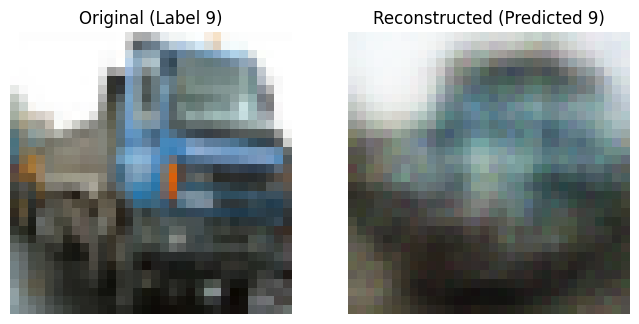

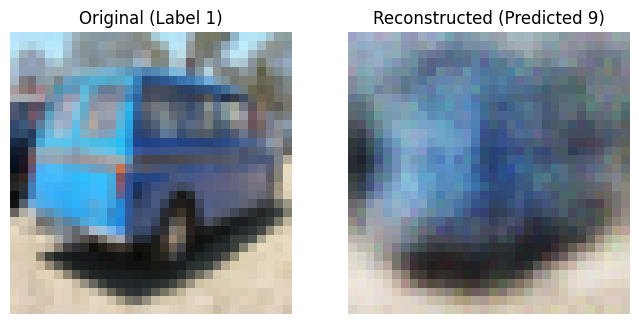

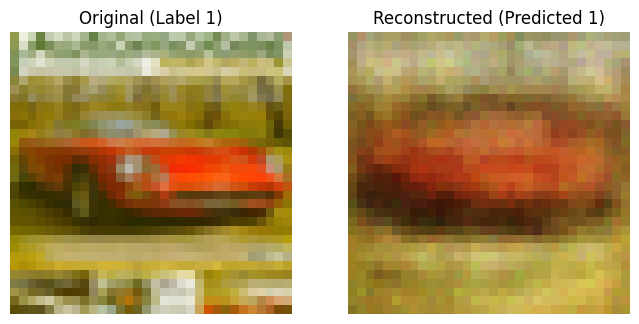


Visualizing results for version2


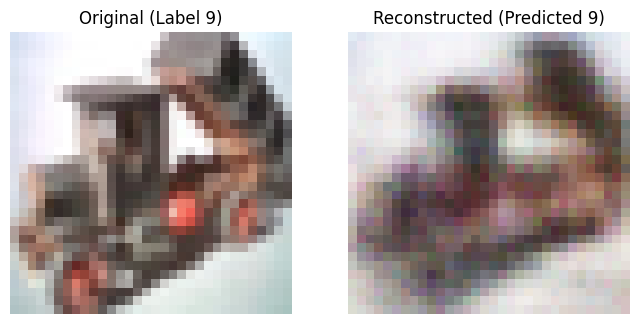

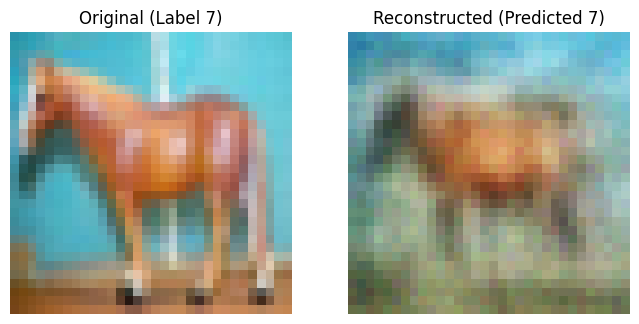

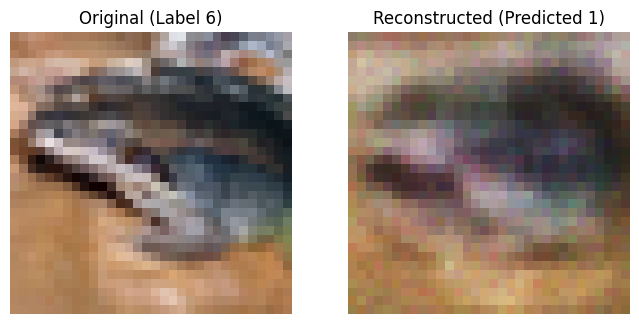


Visualizing results for version3


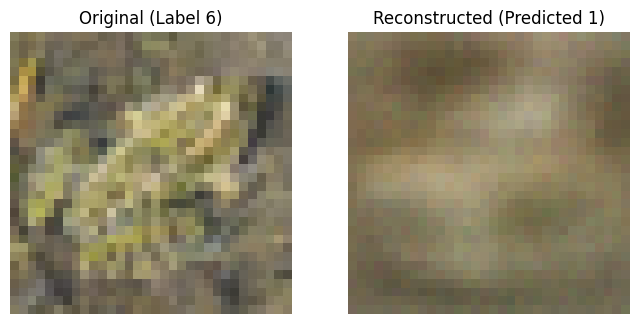

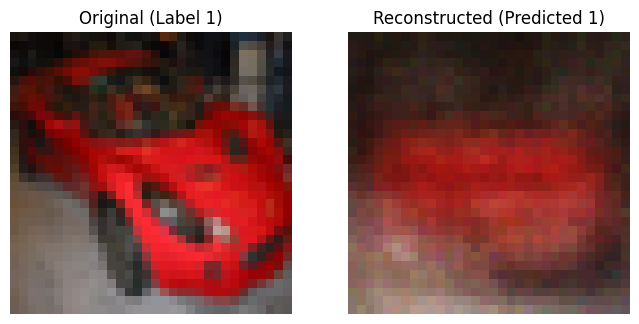

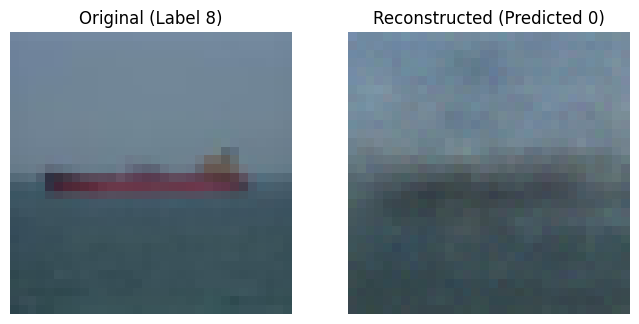

In [48]:
for version_name, models_dict in autoencoder_models_versions.items():

    print("\nVisualizing results for", version_name)


    # Select 3 random test samples
    random_indices = np.random.choice(len(test_dataset), 3, replace=False)

    for index in random_indices:

        test_image, true_label = test_dataset[index]
        predicted_class, error_values = classify_sample_autoencoder(test_image, models_dict)

        model = models_dict[predicted_class]
        model.eval()

        with torch.no_grad():
            test_image_flat = test_image.view(1, -1).to(device)
            reconstructed_flat = model(test_image_flat)
        

        # Reshape images back to (3, 32, 32)
        original_image = test_image.numpy().transpose(1, 2, 0)
        reconstructed_image = reconstructed_flat.cpu().view(3, 32, 32).numpy().transpose(1, 2, 0)


        # Rescale images from [-1, 1] back to [0, 1] for display
        original_image = (original_image * 0.5) + 0.5
        reconstructed_image = (reconstructed_image * 0.5) + 0.5
        

        # Plot original and reconstructed images side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title("Original (Label " + str(true_label) + ")")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_image)
        plt.title("Reconstructed (Predicted " + str(predicted_class) + ")")
        plt.axis("off")
        plt.show()


Draw Comparison Graph for All Versions

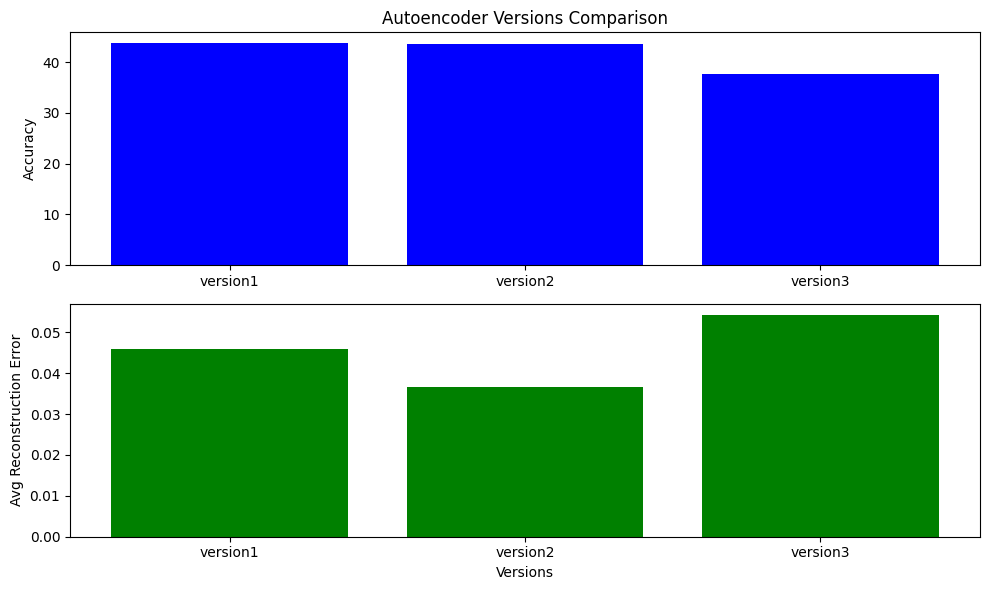

The best autoencoder version is version1 with accuracy 43.69


In [49]:
version_names = []
accuracy_list = []
error_list = []

for version_name, metrics in evaluation_metrics_task3.items():

    version_names.append(version_name)
    accuracy_list.append(metrics["accuracy"])
    error_list.append(metrics["average_reconstruction_error"])


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.bar(version_names, accuracy_list, color="blue")


plt.ylabel("Accuracy")
plt.title("Autoencoder Versions Comparison")


plt.subplot(2, 1, 2)
plt.bar(version_names, error_list, color="green")


plt.ylabel("Avg Reconstruction Error")
plt.xlabel("Versions")
plt.tight_layout()
plt.show()


best_version_task3 = max(evaluation_metrics_task3.keys(), key=lambda v: evaluation_metrics_task3[v]["accuracy"])
print("The best autoencoder version is", best_version_task3, "with accuracy", evaluation_metrics_task3[best_version_task3]["accuracy"])


now we will comapare all the diff versions 

Best PCA version (Task 1): version3 Accuracy: 38.73
Best Neural Network version (Task 2): version3 Accuracy: 70.98
Best Autoencoder version (Task 3): version1 Accuracy: 43.69


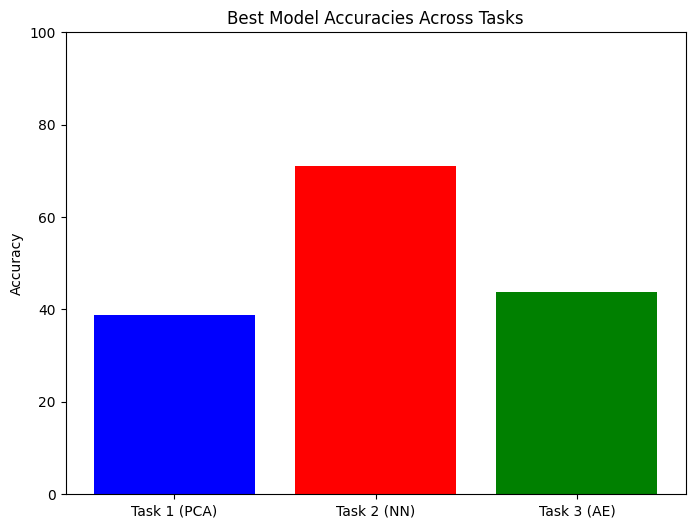

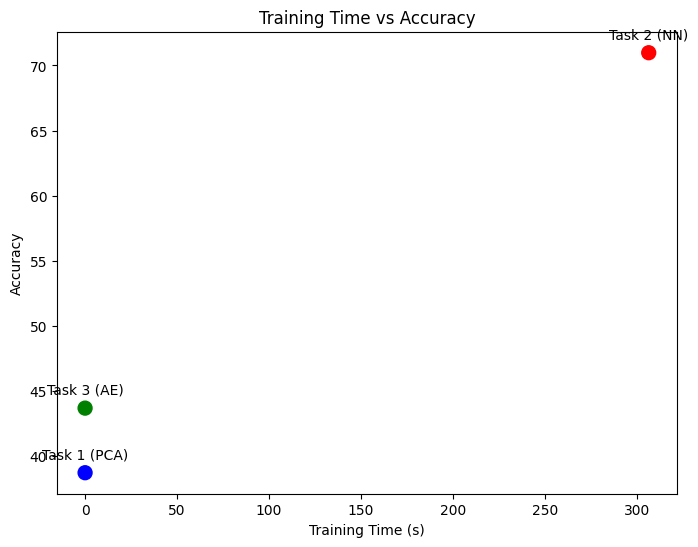

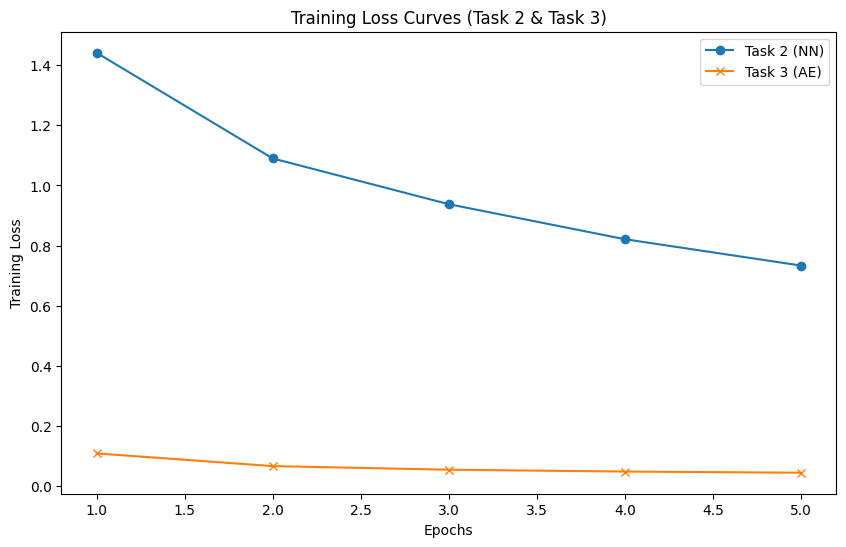

Overall best method: Task 2 (Neural Network)


In [ ]:

best_task1_version = max(evaluation_metrics["pca_versions"].keys(), key=lambda v: evaluation_metrics["pca_versions"][v]["accuracy"])
best_task1_data = evaluation_metrics["pca_versions"][best_task1_version]
best_task1_accuracy = best_task1_data.get("accuracy", 0)
task1_training_time = best_task1_data.get("training_time", 0)

best_task2_version = max(evaluation_metrics_task2.keys(), key=lambda v: evaluation_metrics_task2[v]["accuracy"])
best_task2_data = evaluation_metrics_task2[best_task2_version]
best_task2_accuracy = best_task2_data.get("accuracy", 0)
task2_training_time = best_task2_data.get("training_time", 0)
loss_curve_task2 = best_task2_data.get("loss_curve", [])

best_task3_version = max(evaluation_metrics_task3.keys(), key=lambda v: evaluation_metrics_task3[v]["accuracy"])
best_task3_data = evaluation_metrics_task3[best_task3_version]
best_task3_accuracy = best_task3_data.get("accuracy", 0)
task3_training_time = best_task3_data.get("training_time", 0)
loss_curves = [autoencoder_loss_curves_versions[best_task3_version][k] for k in autoencoder_loss_curves_versions[best_task3_version]]
loss_curve_task3 = np.mean(loss_curves, axis=0) if loss_curves else []

print("Best PCA version (Task 1):", best_task1_version, "Accuracy:", best_task1_accuracy)
print("Best Neural Network version (Task 2):", best_task2_version, "Accuracy:", best_task2_accuracy)
print("Best Autoencoder version (Task 3):", best_task3_version, "Accuracy:", best_task3_accuracy)

task_names = ["Task 1 (PCA)", "Task 2 (NN)", "Task 3 (AE)"]
accuracies = [best_task1_accuracy, best_task2_accuracy, best_task3_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(task_names, accuracies, color=["blue", "red", "green"])
plt.ylabel("Accuracy")
plt.title("Best Model Accuracies Across Tasks")
plt.ylim(0, 100)
plt.show()

training_times = [task1_training_time, task2_training_time, task3_training_time]
plt.figure(figsize=(8, 6))
plt.scatter(training_times, accuracies, color=["blue", "red", "green"], s=100)
for i, txt in enumerate(task_names):
    plt.annotate(txt, (training_times[i], accuracies[i]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.xlabel("Training Time (s)")
plt.ylabel("Accuracy")
plt.title("Training Time vs Accuracy")
plt.show()

plt.figure(figsize=(10, 6))
if loss_curve_task2:
    epochs_task2 = list(range(1, len(loss_curve_task2) + 1))
    plt.plot(epochs_task2, loss_curve_task2, marker='o', label="Task 2 (NN)")
if len(loss_curve_task3) > 0:
    epochs_task3 = list(range(1, len(loss_curve_task3) + 1))
    plt.plot(epochs_task3, loss_curve_task3, marker='x', label="Task 3 (AE)")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves (Task 2 & Task 3)")
plt.legend()
plt.show()

if best_task1_accuracy >= best_task2_accuracy and best_task1_accuracy >= best_task3_accuracy:
    overall_best = "Task 1 (PCA)"
elif best_task2_accuracy >= best_task1_accuracy and best_task2_accuracy >= best_task3_accuracy:
    overall_best = "Task 2 (Neural Network)"
else:
    overall_best = "Task 3 (Autoencoder)"
print("Overall best method:", overall_best)
